In [1]:
import sys
# load standard python modules
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# load torch modules
import torch
import torch.nn as nn
import torch.nn.functional as F

from modules.file_readers import phi_wrap, pandas_to_unclustered_particles, get_highest_mass_constituents, pandas_to_features, select_jets_1, select_jets_2 
from modules.jet_visualizers import plot_jets_phase_plane, plot_nsubs
from modules.jet_augs import apply_single_jet_augs, translate_jets, rotate_jets, rescale_pts, distort_jets, collinear_fill_jets, crop_jets
from modules.jet_vars import nsub, convert_constits_coords


In [2]:
# choose from: "02092021", "dijet"

study_type = "dijet"


# Load in the data

Starts with a dataset of particles $p_T$, $\eta$, $\phi$

Clusters into jets, takes highest mass jet, returns the constituents ordered by pT

Dataset shape: (n,3,101) = (n,[$p_T$, $\eta$, $\phi$],1 jet + 100 constituents)

In [3]:
clustered_npy_exists = True

path_to_unclustered = "/clusterfs/ml4hep/rrmastandrea/LHC0/events_anomalydetection.h5"
path_to_data_storage = "/clusterfs/ml4hep/rrmastandrea/processed_data/"+study_type+"/"

if not clustered_npy_exists:
    
    start = 215000
    stop = 220000
    jetR = 0.8
    j_per_e = 2
    center = "J1_phi_only_pi_2"
    ncon_store = 50
    
    fname_data = "dijet_data_jetR_"+str(jetR)+"_"+center+"_"+str(start)+"_"+str(stop)+".npy"
    fname_labels = "dijet_labels_jetR_"+str(jetR)+"_"+center+"_"+str(start)+"_"+str(stop)+".npy"
    
    
    print("Reading in unclustered events...")
    # Read in the file
    unclustered_particles_data = pd.read_hdf(path_to_unclustered,start = start, stop = stop)
    # Convert pd to numpy; get labels
    unclustered_collisions, unclustered_particles_labels = pandas_to_unclustered_particles(unclustered_particles_data)
    # Cluster into jets, get highest mass constituents
    high_mass_consits_wjet, bad_indices = get_highest_mass_constituents(unclustered_collisions, jetR, center = center, j_per_e = j_per_e, ncon_store=ncon_store)
    high_mass_labels = np.delete(unclustered_particles_labels,bad_indices)
    np.save(path_to_data_storage+fname_data, high_mass_consits_wjet)
    np.save(path_to_data_storage+fname_labels, high_mass_labels)
    print("Saved file "+fname_data)
    print("Saved file "+fname_labels)
    
    print(high_mass_consits_wjet.shape,unclustered_particles_labels.shape)

    
if clustered_npy_exists: 
    
    jetR = 0.8
    
    j_per_e = 2
    center = "J1_phi_only_pi_2"
    

    if study_type == "02092021":
        starts_and_stops = [(0,5000),(5000,10000),(10000,15000),(15000,20000),
                       (20000,25000),(25000,30000),(30000,35000),(35000,40000),
                       (40000,45000),(45000,50000),(50000,55000),(55000,60000),
                      (60000,65000),(65000,70000),(70000,75000)]#,(75000,80000),
                       #(80000,85000),(85000,90000),(90000,95000),(95000,100000)]
    elif study_type == "dijet":
    
        starts_and_stops = [(0,2000),(2000,6000),(6000,10000),(10000,15000),
                            (15000,20000), (20000,25000), (25000,30000),(30000,35000),
                            (35000,40000),(40000,45000),(50000,55000), (55000,60000),
                            (60000,65000),(65000,70000),(70000,75000),(75000,80000),
                            (80000,85000),(85000,90000),(90000,95000),(95000,100000),
                           (100000,105000),(105000,110000),(110000,115000),(115000,120000),
                           (120000,125000),(125000,130000),(130000,135000),(135000,140000),
                           (140000,145000),(145000,150000),(150000,155000),(155000,160000),
                           (160000,165000),(165000,170000),(170000,175000),(175000,180000),
                           (180000,185000),(185000,190000),(190000,195000),(195000,200000),
                           (200000,205000),(205000,210000),(210000,215000),
                           (215000,220000)]

    """
    high_mass_consits_wjet = np.load(path_to_data_storage+"highmassconstits_data_jetR_"+str(jetR)+"_deltaJ_"+str(starts_and_stops[0][0])+"_"+str(starts_and_stops[0][1])+".npy")
    high_mass_labels = np.load(path_to_data_storage+"highmassconstits_labels_jetR_"+str(jetR)+"_deltaJ_"+str(starts_and_stops[0][0])+"_"+str(starts_and_stops[0][1])+".npy")

    for ss in starts_and_stops[1:]:
        high_mass_consits_wjet = np.concatenate([high_mass_consits_wjet, np.load(path_to_data_storage+"highmassconstits_data_jetR_"+str(jetR)+"_deltaJ_"+str(ss[0])+"_"+str(ss[1])+".npy")])
        high_mass_labels = np.concatenate([high_mass_labels, np.load(path_to_data_storage+"highmassconstits_labels_jetR_"+str(jetR)+"_deltaJ_"+str(ss[0])+"_"+str(ss[1])+".npy")])
    """
        
    high_mass_consits_wjet = np.load(path_to_data_storage+"dijet_data_jetR_"+str(jetR)+"_"+center+"_"+str(starts_and_stops[0][0])+"_"+str(starts_and_stops[0][1])+".npy")
    high_mass_labels = np.load(path_to_data_storage+"dijet_labels_jetR_"+str(jetR)+"_"+center+"_"+str(starts_and_stops[0][0])+"_"+str(starts_and_stops[0][1])+".npy")

   
    for ss in starts_and_stops[1:]:
        high_mass_consits_wjet = np.concatenate([high_mass_consits_wjet, np.load(path_to_data_storage+"dijet_data_jetR_"+str(jetR)+"_"+center+"_"+str(ss[0])+"_"+str(ss[1])+".npy")])
        high_mass_labels = np.concatenate([high_mass_labels, np.load(path_to_data_storage+"dijet_labels_jetR_"+str(jetR)+"_"+center+"_"+str(ss[0])+"_"+str(ss[1])+".npy")])

    
    
  
    
    print("Read in files")
    print("Data shape: ",high_mass_consits_wjet.shape)
    print("Labels shape:", high_mass_labels.shape)
          

Read in files
Data shape:  (214986, 3, 102)
Labels shape: (214986,)


## Jet cuts 

Cut on $p_t$, $\eta$ of the jets 

Then split into signal and background datasets

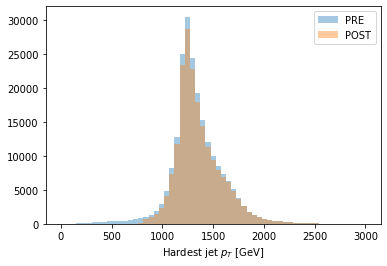

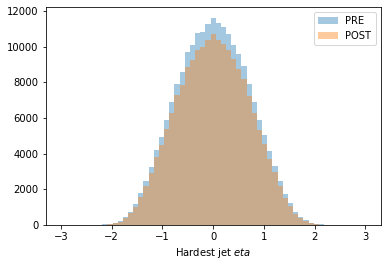

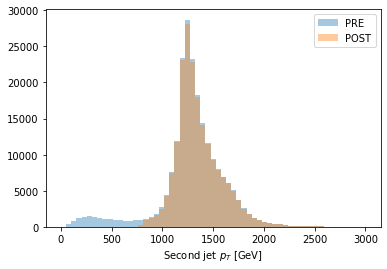

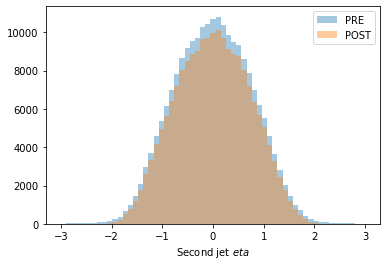

In [4]:
# Select jets of interest

# pT, eta cuts
pt_cut_0 = [800,3000]
eta_cut_0 = [-3,3]
pt_cut_1 = [800,3000]
eta_cut_1 = [-3,3]


if study_type == "02092021":
    high_mass_consits_wjet_cut, high_mass_labels_cut = select_jets_1(high_mass_consits_wjet, high_mass_labels, pt_cut_0, eta_cut_0)


elif study_type == "dijet":
    n_const = 50
    high_mass_consits_wjet_cut, high_mass_labels_cut = select_jets_2(high_mass_consits_wjet, high_mass_labels, n_const, pt_cut_0, pt_cut_1, eta_cut_0, eta_cut_1)



# plot the jet parameters for jet 1

plt.figure()
plt.hist(high_mass_consits_wjet[:,0,0], bins = np.linspace(0,3000,60), alpha = 0.4, label = "PRE")
plt.hist(high_mass_consits_wjet_cut[:,0,0], bins = np.linspace(0,3000,60), alpha = 0.4, label = "POST")
plt.legend()
plt.xlabel("Hardest jet $p_T$ [GeV]")
plt.show()

plt.figure()
plt.hist(high_mass_consits_wjet[:,1,0], bins = np.linspace(-3,3,60), alpha = 0.4, label = "PRE")
plt.hist(high_mass_consits_wjet_cut[:,1,0], bins = np.linspace(-3,3,60), alpha = 0.4, label = "POST")
plt.legend()
plt.xlabel("Hardest jet $eta$")
plt.show()

if study_type == "dijet":

    # plot the jet parameters for jet 2

    plt.figure()
    plt.hist(high_mass_consits_wjet[:,0,n_const+1], bins = np.linspace(0,3000,60), alpha = 0.4, label = "PRE")
    plt.hist(high_mass_consits_wjet_cut[:,0,n_const+1], bins = np.linspace(0,3000,60), alpha = 0.4, label = "POST")
    plt.legend()
    plt.xlabel("Second jet $p_T$ [GeV]")
    plt.show()

    plt.figure()
    plt.hist(high_mass_consits_wjet[:,1,n_const+1], bins = np.linspace(-3,3,60), alpha = 0.4, label = "PRE")
    plt.hist(high_mass_consits_wjet_cut[:,1,n_const+1], bins = np.linspace(-3,3,60), alpha = 0.4, label = "POST")
    plt.legend()
    plt.xlabel("Second jet $eta$")
    plt.show()


# Last data preprocessing

-- removing the jet from the jet + constituents array

-- rescaling the pt

-- splitting into signal vs background

-- crop the jets

-- adding zero pad for collinear splitting

Initial array shape: (195869, 3, 102)
On jet 0
Cropping the jets to 50 consituents
Adding a zero pad of size 0

On jet 1
Cropping the jets to 50 consituents
Adding a zero pad of size 0

Final array shape: (195869, 3, 102)

(3, 102)
Max pt: 2990.887183263665 ; max eta: 2.865673303604126 ; max phi: 3.1415818626001113
Signal shape: (18918, 3, 102)
Background shape: (176951, 3, 102)


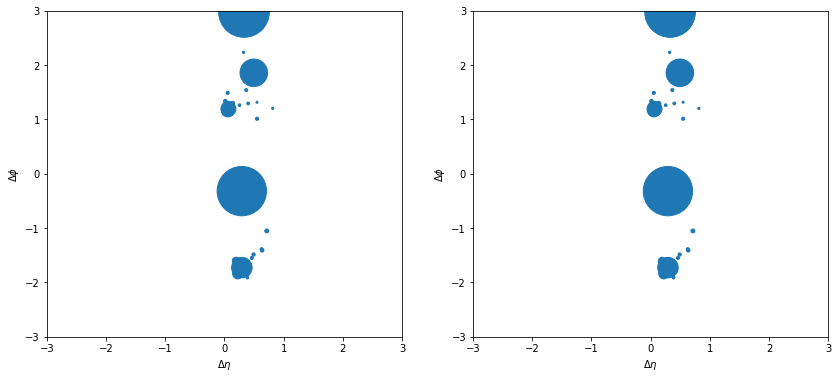

In [5]:
def zero_pad_consts(data, n):
        zero_pad = np.zeros((data.shape[0],3,n-data.shape[2]))
        data = np.concatenate((data,zero_pad), axis = 2)
        return data

j_per_e  = 2

print("Initial array shape:", high_mass_consits_wjet_cut.shape)

# split the event into the jets
split_jets = np.split(high_mass_consits_wjet_cut, j_per_e, axis = 2)
modified_jets = []

# now go through each jet
for i, subjet in enumerate(split_jets):
    print("On jet", i)
    
    # Take only the constituents (i.e. drop the 0th, which is the jet)
    #subjet = subjet[:,:,1:]
    
    # crop the n constituents
    n_nonzero_conts = 50
    print("Cropping the jets to",n_nonzero_conts,"consituents")
    subjet = crop_jets(subjet,1+n_nonzero_conts)
    
    # add zero pad
    n_zero_pad = 0
    print("Adding a zero pad of size", n_zero_pad)
    subjet = zero_pad_consts(subjet,n_zero_pad+n_nonzero_conts+1)
    
    modified_jets.append(subjet)
    print()
    
# recombine the jets
high_mass_consits = np.concatenate(modified_jets, axis = 2)
print("Final array shape:", high_mass_consits.shape)
print()

jet_to_plot = high_mass_consits[2]
print(jet_to_plot.shape) 
plot_jets_phase_plane(jet_to_plot, jet_to_plot,2,(-3,3),(-3,3))   


# get max, min pt for normalizing
max_pt = np.max(high_mass_consits[:,0,:])
max_eta = np.max(high_mass_consits[:,1,:])
max_phi = np.max(high_mass_consits[:,2,:])
                  
print("Max pt:",max_pt,"; max eta:", max_eta, "; max phi:", max_phi)

# rescale the pts here

rescale_denom_pt = max_pt/10
#print("Rescaling all pTs by",rescale_denom_pt)
#high_mass_consits = rescale_pts( high_mass_consits, rescale_denom_pt ) 

# split into signal vs background


high_mass_consits_sig = high_mass_consits[np.where(high_mass_labels_cut==1)]
high_mass_consits_bkg = high_mass_consits[np.where(high_mass_labels_cut==0)]


print("Signal shape:", high_mass_consits_sig.shape)
print("Background shape:", high_mass_consits_bkg.shape)



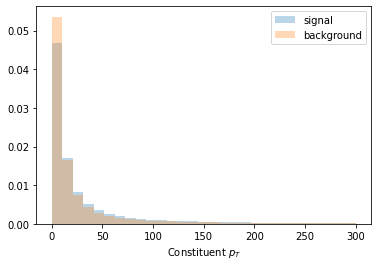

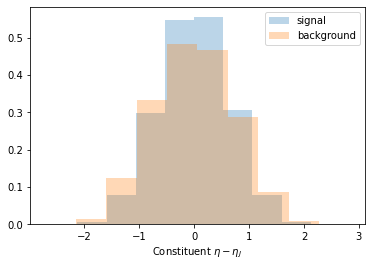

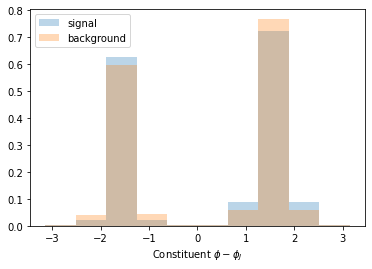

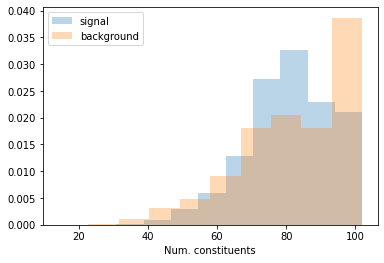

In [6]:
# Plots of pt, eta, phi for the constituents

N_start = 0  # Number of collision events
N_stop = 70000

M = 100  # Number of constituents


plt.figure()
loc_plot = np.reshape(high_mass_consits_sig[N_start:N_stop,0,0:M],((N_start-N_stop)*(M),))
plt.hist(loc_plot[loc_plot != 0]/1.0, bins = np.linspace(0,300,30), alpha = .3, density=True, label = "signal")
loc_plot = np.reshape(high_mass_consits_bkg[N_start:N_stop,0,0:M],((N_start-N_stop)*(M),))
plt.hist(loc_plot[loc_plot != 0]/1.0, bins = np.linspace(0,300,30), alpha = .3, density=True, label = "background")
plt.xlabel("Constituent $p_T$")
#plt.xlim(0,5000)
plt.legend()
plt.show()


plt.figure()
loc_plot = np.reshape(high_mass_consits_sig[N_start:N_stop,1,0:M],((N_start-N_stop)*(M),))
plt.hist(loc_plot[loc_plot != 0], alpha = .3, density=True, label = "signal")
loc_plot = np.reshape(high_mass_consits_bkg[N_start:N_stop,1,0:M],((N_start-N_stop)*(M),))
plt.hist(loc_plot[loc_plot != 0], alpha = .3, density=True, label = "background")
plt.xlabel("Constituent $\eta-\eta_J$")
plt.legend()
plt.show()


plt.figure()
loc_plot = np.reshape(high_mass_consits_sig[N_start:N_stop,2,0:M],((N_start-N_stop)*(M),))
plt.hist(loc_plot[loc_plot != 0], alpha = .3, density=True, label = "signal")
loc_plot = np.reshape(high_mass_consits_bkg[N_start:N_stop,2,0:M],((N_start-N_stop)*(M),))
plt.hist(loc_plot[loc_plot != 0], alpha = .3, density=True, label = "background")
plt.xlabel("Constituent $\phi-\phi_J$")
plt.legend()
plt.show()


# Plot num constituents

def get_num_constits(dataset):
    consits_list = []
    for collision in dataset:
        pts = collision[0,:]

        pads = np.where(pts==0)
        consits_list.append(dataset.shape[2]-len(pads[0]))
        
    return consits_list
        

plt.figure()
plt.hist(get_num_constits(high_mass_consits_sig), alpha = .3, density=True, label = "signal")
plt.hist(get_num_constits(high_mass_consits_bkg), alpha = .3, density=True, label = "background")
plt.xlabel("Num. constituents")
plt.legend()
plt.show()





# Split the data into test / train / validation sets

- CLR training: First ```num_clr_train``` background events
- CLR val: 20% of CLR train

- Classification training: (up to) ```njets_sig``` signal, ```njets_bkg``` background
- Classification test: 30% of training
- Classification test is further split into validation / test



In [7]:

# creating the training dataset

n_constits_max = n_nonzero_conts

"""
RUN THE JET SELECTOR CODE
"""

t0 = time.time()

"""
Make the CLR train and val datasets
"""
num_clr_train_sig = 10000
num_clr_train_bkg = 10000
val_size = 0.3
dataset_clr_sig = high_mass_consits_sig[0:num_clr_train_sig,:,:]
dataset_clr_bkg = high_mass_consits_bkg[0:num_clr_train_bkg,:,:]


# split into train - val
((clr_sig_train, clr_sig_val),
 (clr_bkg_train, clr_bkg_val),
 ) = [train_test_split(arr, test_size=val_size) for arr in [
    dataset_clr_sig,
    dataset_clr_bkg,
]]

# preparing the training dataset w/ labels
clr_train = np.concatenate([clr_sig_train,clr_bkg_train])
clr_train = shuffle(clr_train)

# preparing the test dataset(s)
clr_val = np.concatenate([clr_sig_val,clr_bkg_val])
clr_val = shuffle(clr_val)


"""
Make the classification datasets
"""
njets_sig = 50000
njets_bkg = 60000

# take only however many constituents and jets we want 
dataset_sample_sig = high_mass_consits_sig[0:njets_sig,:,:]
dataset_sample_bkg = high_mass_consits_bkg[0:njets_bkg,:,:]


print("Num signal:", dataset_sample_sig.shape[0],"; Num background:", dataset_sample_bkg.shape[0])

# split into train - val 
test_size = .3
((sig_train, sig_test),
 (bkg_train, bkg_test),
 ) = [train_test_split(arr, test_size=test_size) for arr in [
    dataset_sample_sig,
    dataset_sample_bkg,
]]

# preparing the training dataset w/ labels
data_train = np.concatenate([sig_train,bkg_train])
labels_train = np.concatenate([np.ones(sig_train.shape[0]),np.zeros(bkg_train.shape[0])])
data_train, labels_train = shuffle(data_train, labels_train)

# preparing the test dataset(s)
data_test = np.concatenate([sig_test,bkg_test])
labels_test = np.concatenate([np.ones(sig_test.shape[0]),np.zeros(bkg_test.shape[0])])
data_test, labels_test = shuffle(data_test, labels_test)

# Split the test into val + "testf"
lct_val_size = .6
n_val = int(data_test.shape[0]*lct_val_size)
data_val = data_test[0:n_val,:,:]
labels_val = labels_test[0:n_val]
data_test_f = data_test[n_val:,:,:]
labels_test_f = labels_test[n_val:]

# print data dimensions
print( "CLR training data shape: " + str( clr_train.shape ), flush=True)
print( "CLR val data shape: " + str( clr_val.shape ), flush=True)
print( "BC training data shape: " + str( data_train.shape ), flush=True)
print( "BC training labels shape: " + str( labels_train.shape ), flush=True)
print( "BC val data shape: " + str( data_val.shape ), flush=True)
print( "BC val labels shape: " + str( labels_val.shape ), flush=True)
print( "BC test data shape: " + str( data_test_f.shape ), flush=True)
print( "BC test labels shape: " + str( labels_test_f.shape ), flush=True)


t1 = time.time()

print( "time taken to load and preprocess data: "+str( np.round( t1-t0, 2 ) ) + " seconds", flush=True  )
print()

Num signal: 18918 ; Num background: 60000
CLR training data shape: (14000, 3, 102)
CLR val data shape: (6000, 3, 102)
BC training data shape: (55242, 3, 102)
BC training labels shape: (55242,)
BC val data shape: (14205, 3, 102)
BC val labels shape: (14205,)
BC test data shape: (9471, 3, 102)
BC test labels shape: (9471,)
time taken to load and preprocess data: 0.14 seconds



In [8]:
path_to_save_dir = "/global/home/users/rrmastandrea/training_data/"


n_sig_total = dataset_sample_sig.shape[0]
n_bkg_total = dataset_sample_bkg.shape[0]


save_id_dir = "n_sig_"+str(n_sig_total)+"_n_bkg_"+str(n_bkg_total)+"_n_nonzero_"+str(n_nonzero_conts)+"_n_pad_"+str(n_zero_pad)+"_n_jet_"+str(j_per_e)+"/"

path_to_save_dir += save_id_dir
print(path_to_save_dir)

if os.path.isdir(path_to_save_dir):
    print("ERROR: experiment already exists, don't want to overwrite it by mistake")
    pass
else:
    os.makedirs(path_to_save_dir)
    
np.save(path_to_save_dir+"clr_train.npy",clr_train)
np.save(path_to_save_dir+"clr_val.npy",clr_val)
np.save(path_to_save_dir+"data_train.npy",data_train)
np.save(path_to_save_dir+"labels_train.npy",labels_train)
np.save(path_to_save_dir+"data_val.npy",data_val)
np.save(path_to_save_dir+"labels_val.npy",labels_val)
np.save(path_to_save_dir+"data_test_f.npy",data_test_f)
np.save(path_to_save_dir+"labels_test_f.npy",labels_test_f)

/global/home/users/rrmastandrea/training_data/n_sig_18918_n_bkg_60000_n_nonzero_50_n_pad_0_n_jet_2/
